The following example shows how to train a model. Get a list of training data csv file in the selected folder. Lessons learned so far:
- Training result is very sensitive to normalization. The normalization approach based on mean and variance does not work very well. Still need to manually set mean and variance.
- t-sne plot of adapter trace is an important flag of training result. 
- h net does not have to descent because phi net training strives to make it rise, while h net training itself tries to lower the loss
- Increase the h training frequency to fight against rising h 
- Increase alpha to push domain info to adapter
- Increase number of features to minimize MSE loss.
- ocassional small spike in cross entropy loss is possibly a sign that phi net become further domain invariant and may not be bad.
- at the late stage of training while both mse loss and cross entropy loss converge. May need to train h net every step to refine the optimization direction.
- Do not need to select the model at the end epoch. Select the epoch when the loss is reasonably low and stable. 
- RMS is a good indicator because it matches the least square form of loss function
- When the residual force is small, e.g. training disturbance force compensated by BEMT, disturbance normalization should scale up the label for better learning. 

Existing problem:
- The more classes, the harder to train. The difficulty comes from instability of loss_f and loss_c. alpha is hard to tune.
- t-sne gets worse as epoch grows and the cross entropy loss remains the same. 

In [1]:
import os
import matplotlib.pyplot as plt

import training_manager

current_dir = os.getcwd()
# training_subfolder = "wind_near_wall_wo_bemt_in_control_train_x_only_wind"
# training_subfolder = "wind_near_wall_wo_bemt_in_control_train_z_only_wind"
training_subfolder = "wind_near_wall_wo_bemt_in_control_train_xz_wind"
# training_subfolder = "nf_training_back2back"
# validation_subfolder = "nf_validation_back2back"
validation_subfolder = "wind_near_wall_validation_no_bemt"

def generate_data_list(subfolder):
    """
    Generate a list of data files in the specified subfolder.
    """
    folder_path = os.path.join(os.path.dirname(current_dir), "data", "training", subfolder)
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Filter out files that do not end with .csv
    file_names = [f for f in file_names if f.endswith('.csv')]
    # add subfolder to the file names
    data_list = [os.path.join(subfolder, f) for f in file_names]
    return data_list

data_list = generate_data_list(training_subfolder)
print("Training Data List:")
for data in data_list:
    print(data)

validation_list = generate_data_list(validation_subfolder)
print("\nValidation Data List:")
for data in validation_list:
    print(data)

path1 = os.path.join(training_subfolder, "input_label_map_disturbance_force_label.yaml")
path2 = os.path.join(training_subfolder, "column_map.yaml")

Training Data List:
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z0_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z3_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z5_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_zn3_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_zn5_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_xn1_0_y0_0_z0_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_xn1_0_y0_0_z3_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_xn1_0_y0_0_z5_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_xn1_0_y0_0_zn3_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_b

- Make sure the input_label_map_disturbance_force_label.yaml is in the selected folder. This yaml defines which fields are model inputs and which fields are data labels. 
- Make sure the column_map.yaml is in the selected folder. This yaml maps data fields to the corresponding column in the csv files. This file can be auto-generated by `Simulation\simulation\training_data_user_guide.ipynb`
- If this is the first time to train on this data. The script will normalize the data and save the normalization parameters into a file.

Loading normalization params file from
..\data\training\wind_near_wall_wo_bemt_in_control_train_xz_wind\normalization_params.yaml
[1] loss_phi: 6.48 loss_h: 2.73 loss_validation: 0.69
a_trace: [[-0.03296383]
 [ 4.43245487]
 [-7.4346721 ]
 [-5.00778474]]
[101] loss_phi: 0.44 loss_h: 2.68 loss_validation: 0.37
a_trace: [[-2.21832171]
 [ 3.67654572]
 [ 0.36658958]
 [-9.0237283 ]]
[201] loss_phi: 0.10 loss_h: 2.66 loss_validation: 0.39
a_trace: [[-4.36607471]
 [ 7.70354673]
 [ 4.51755344]
 [ 1.0883337 ]]
[301] loss_phi: 0.12 loss_h: 2.66 loss_validation: 0.44
a_trace: [[-5.12883496]
 [ 6.0658528 ]
 [ 6.07440714]
 [-0.04538267]]
[401] loss_phi: -0.03 loss_h: 2.65 loss_validation: 0.42
a_trace: [[-5.7649947 ]
 [ 6.32364925]
 [ 4.883419  ]
 [ 1.71129048]]


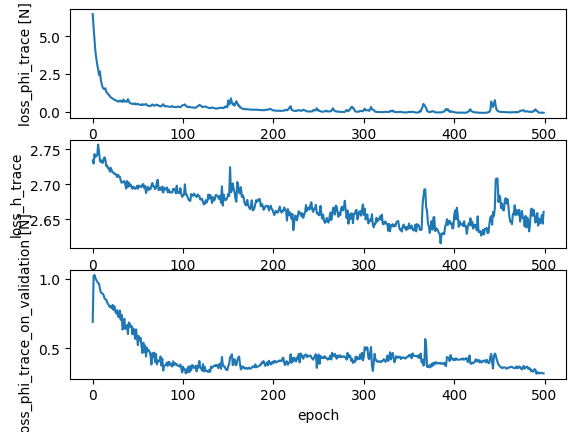

In [2]:
# use the data from previous section to train the model

manager = training_manager.TrainingManager()
manager.set_up(
    data_menu=data_list,
    # data_menu=data_list[:4],    # use small data list for quick testing
    input_label_map_file=path1,
    column_map_file=path2,
    can_skip_io_normalizaiton=False,
    can_inspect_data=False,
    validation_data_menu=validation_list[-1:]
)
plt.show() 
manager.train()
manager.trainer_instance.plot_loss()

plt.show()  

Inspect data in the data list.

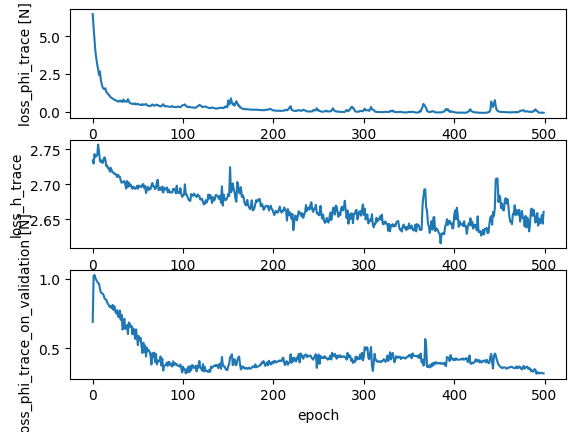

In [3]:
# trainer_instance.inspect_data(data_list[:2])
manager.trainer_instance.plot_loss()

Inspect t-sne of a_trace.

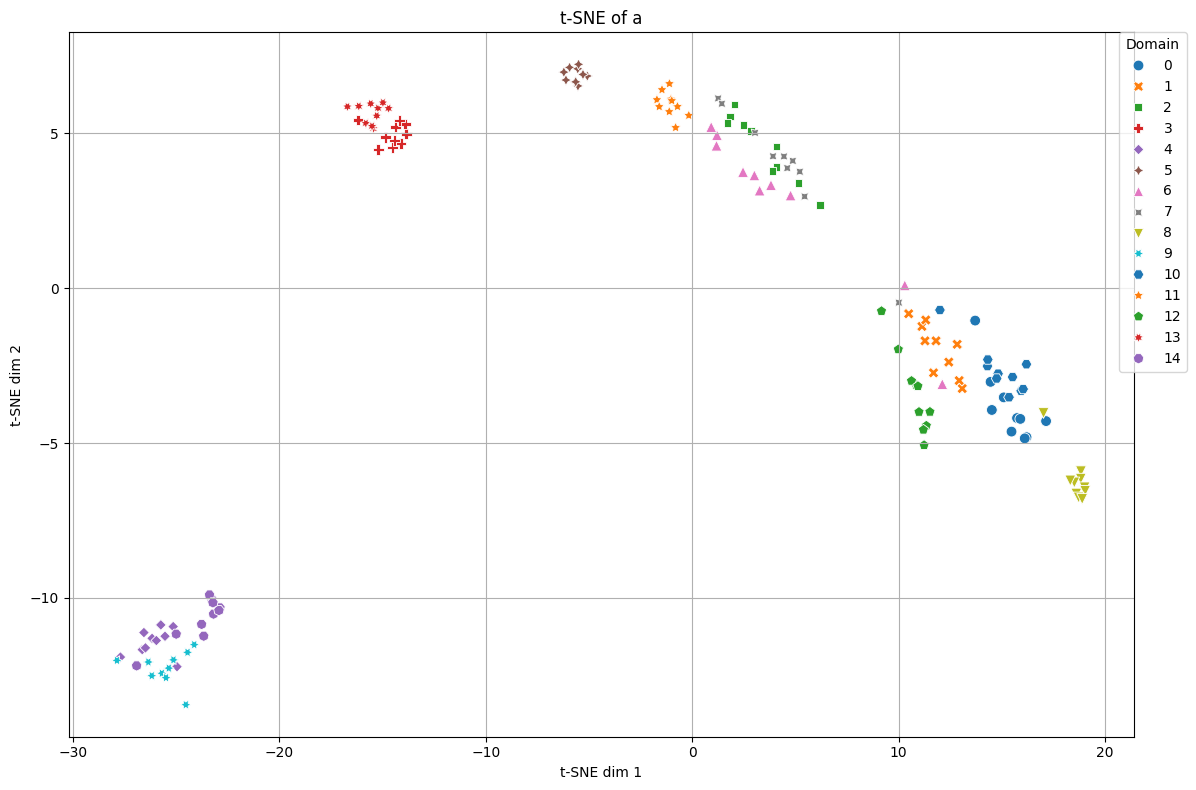

In [4]:
import performance_analyzer
can_print_3d = False
n = 100
performance_analyzer.plot_tsne_of_a(manager.trainer_instance.a_trace, list(range(n, n + 10)))
plt.show()  
if can_print_3d:
    %matplotlib tk
    performance_analyzer.plot_tsne_3d_of_a(manager.trainer_instance.a_trace, list(range(n, n + 10)))


After training, we can save the model in the following way.

In [5]:
model_name = training_subfolder
manager.save_model(model_name)

Model saved to model\wind_near_wall_wo_bemt_in_control_train_xz_wind.pth


Test the model using the test set.

test Data List:
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_zn10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_zn1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_zn4_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_zn10_0_d0_5_validation_no_bemt.csv
wi

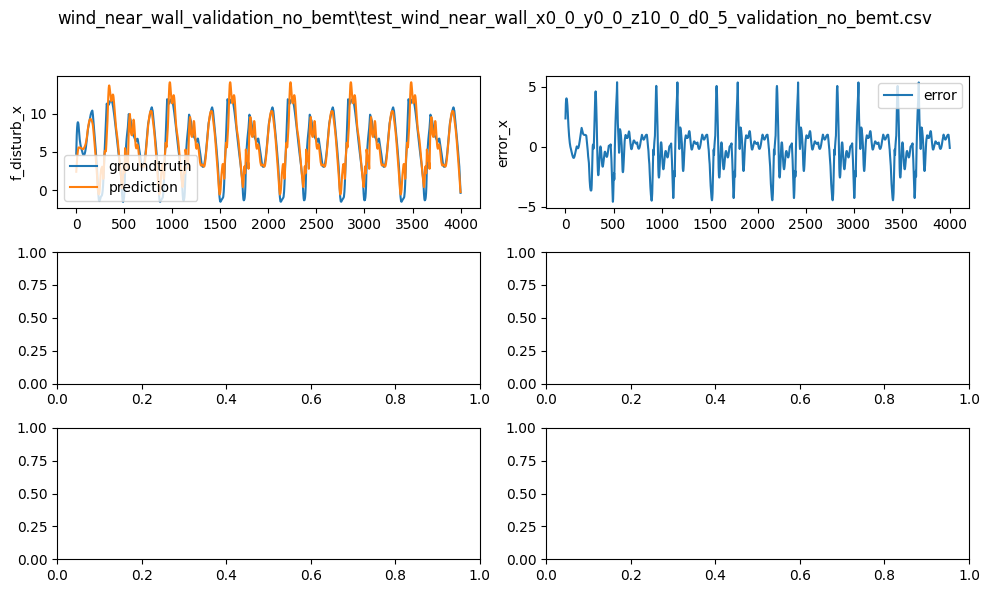

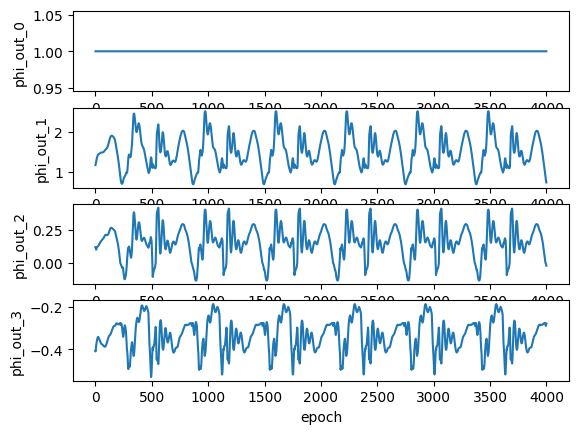

phi_out: tensor([[ 1.0000,  1.1610,  0.1204, -0.4078],
        [ 1.0000,  1.1664,  0.1206, -0.4087],
        [ 1.0000,  1.1709,  0.1208, -0.4095],
        ...,
        [ 1.0000,  0.8438,  0.0101, -0.3586],
        [ 1.0000,  0.8471,  0.0099, -0.3606],
        [ 1.0000,  0.8506,  0.0097, -0.3626]])
a = tensor([[-17.0556],
        [  9.1153],
        [-18.2189],
        [-22.8281]])


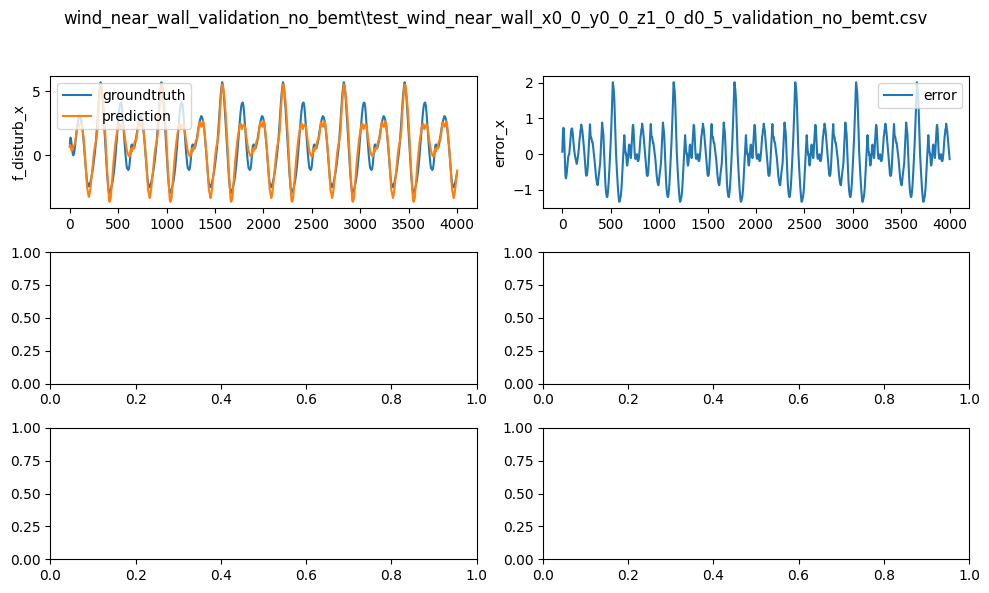

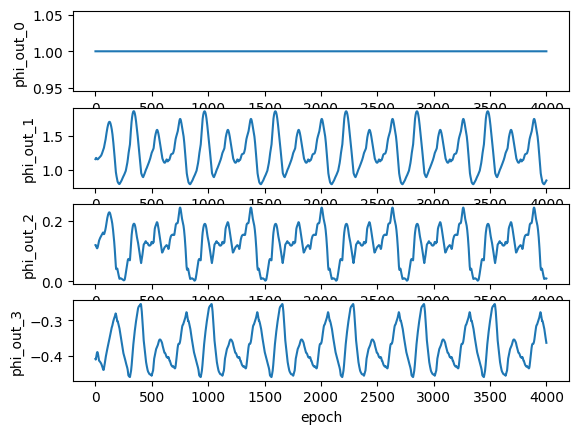

phi_out: tensor([[ 1.0000,  1.1617,  0.1205, -0.4080],
        [ 1.0000,  1.1707,  0.1209, -0.4096],
        [ 1.0000,  1.1786,  0.1204, -0.4093],
        ...,
        [ 1.0000,  0.8065, -0.0052, -0.3423],
        [ 1.0000,  0.8099, -0.0053, -0.3444],
        [ 1.0000,  0.8134, -0.0055, -0.3465]])
a = tensor([[-19.8748],
        [ 10.3832],
        [-15.3171],
        [-30.7209]])


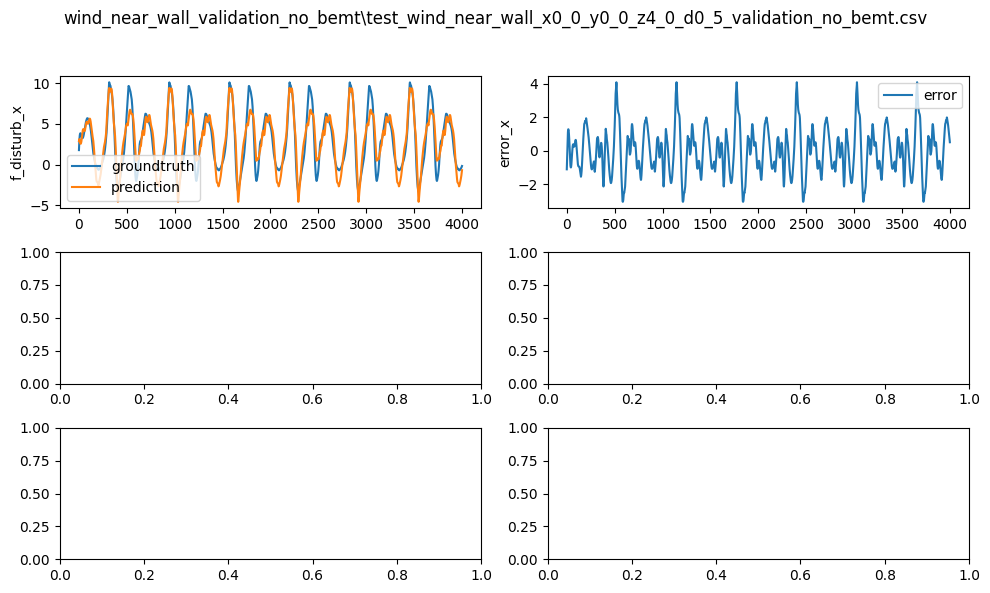

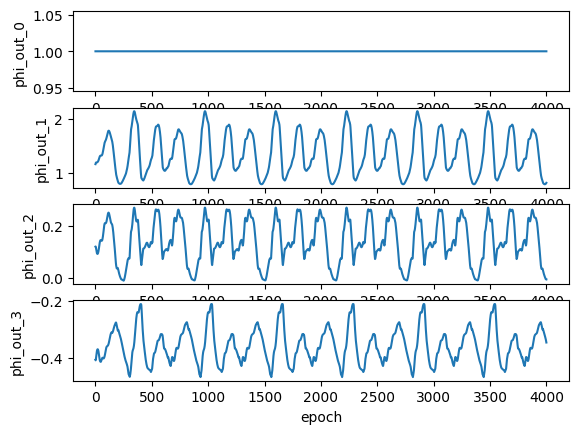

phi_out: tensor([[ 1.0000,  1.1642,  0.1209, -0.4089],
        [ 1.0000,  1.1851,  0.1206, -0.4099],
        [ 1.0000,  1.1999,  0.1164, -0.4046],
        ...,
        [ 1.0000,  0.8154,  0.0053, -0.3240],
        [ 1.0000,  0.8167,  0.0042, -0.3256],
        [ 1.0000,  0.8181,  0.0032, -0.3273]])
a = tensor([[ 1.1476],
        [ 0.6238],
        [ 3.8626],
        [-6.6691]])


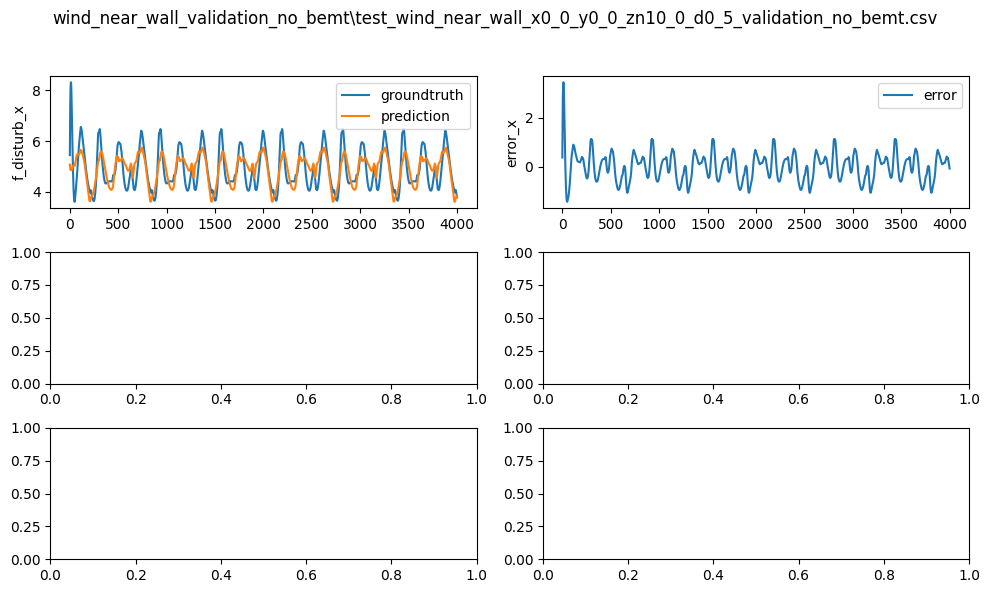

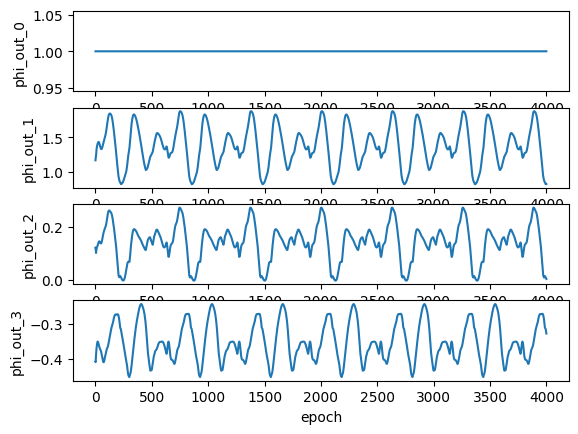

phi_out: tensor([[ 1.0000,  1.1602,  0.1202, -0.4075],
        [ 1.0000,  1.1618,  0.1203, -0.4078],
        [ 1.0000,  1.1626,  0.1203, -0.4080],
        ...,
        [ 1.0000,  0.8438,  0.0085, -0.3563],
        [ 1.0000,  0.8473,  0.0084, -0.3584],
        [ 1.0000,  0.8508,  0.0082, -0.3605]])
a = tensor([[-15.5420],
        [  7.9271],
        [-17.7709],
        [-20.4522]])


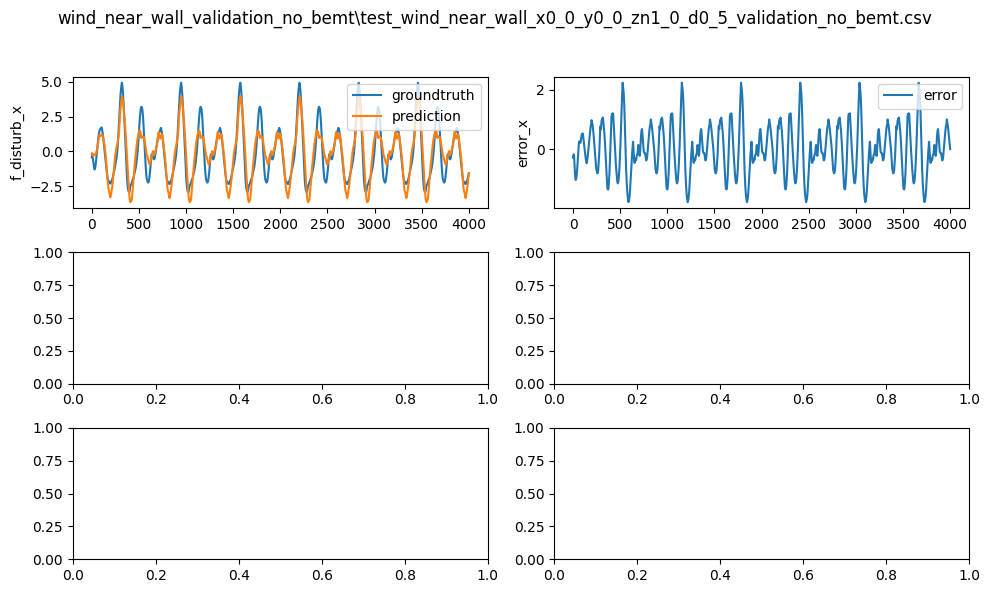

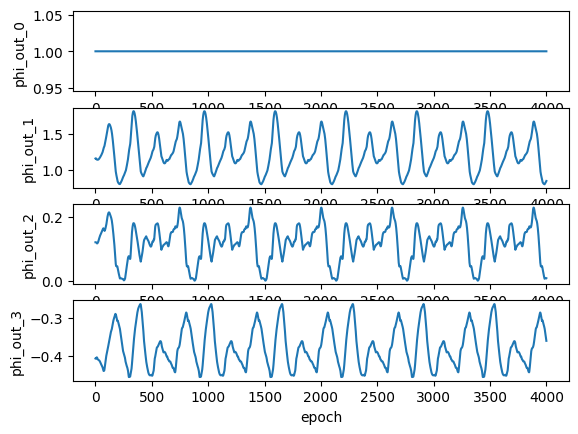

phi_out: tensor([[ 1.0000,  1.1606,  0.1203, -0.4077],
        [ 1.0000,  1.1644,  0.1205, -0.4083],
        [ 1.0000,  1.1674,  0.1206, -0.4089],
        ...,
        [ 1.0000,  0.8235, -0.0047, -0.3436],
        [ 1.0000,  0.8268, -0.0047, -0.3458],
        [ 1.0000,  0.8302, -0.0046, -0.3480]])
a = tensor([[ -8.3350],
        [  3.9869],
        [ -8.8339],
        [-12.4127]])


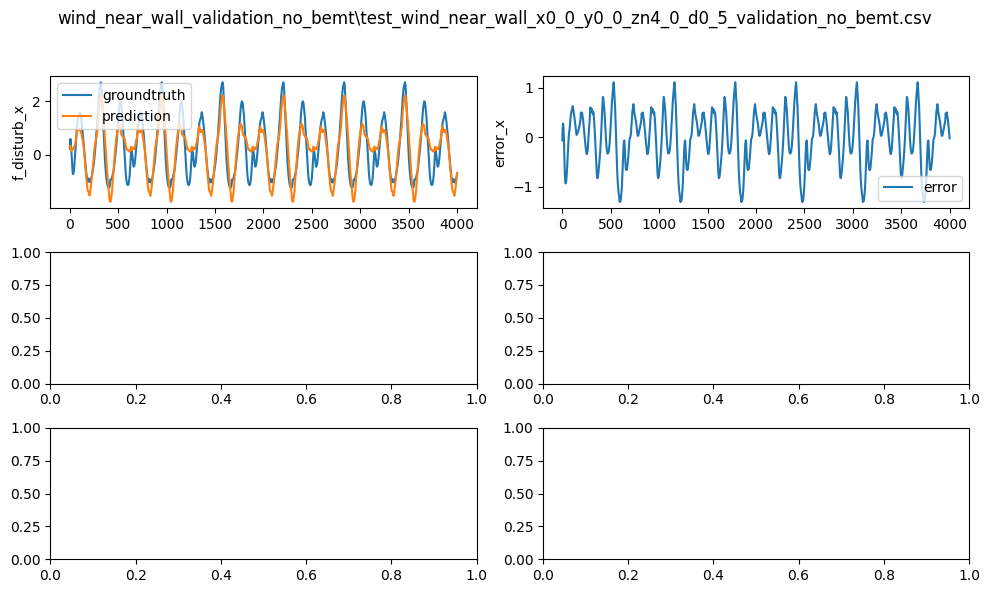

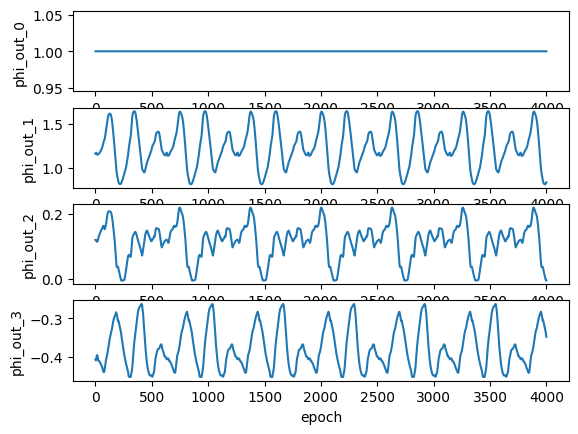

phi_out: tensor([[ 1.0000,  1.1633,  0.1207, -0.4086],
        [ 1.0000,  1.1774,  0.1200, -0.4091],
        [ 1.0000,  1.1868,  0.1161, -0.4033],
        ...,
        [ 1.0000,  0.7970, -0.0111, -0.2920],
        [ 1.0000,  0.7834, -0.0134, -0.2927],
        [ 1.0000,  0.7733, -0.0142, -0.2921]])
a = tensor([[ -6.5177],
        [ 11.0923],
        [-13.5692],
        [  5.6837]])


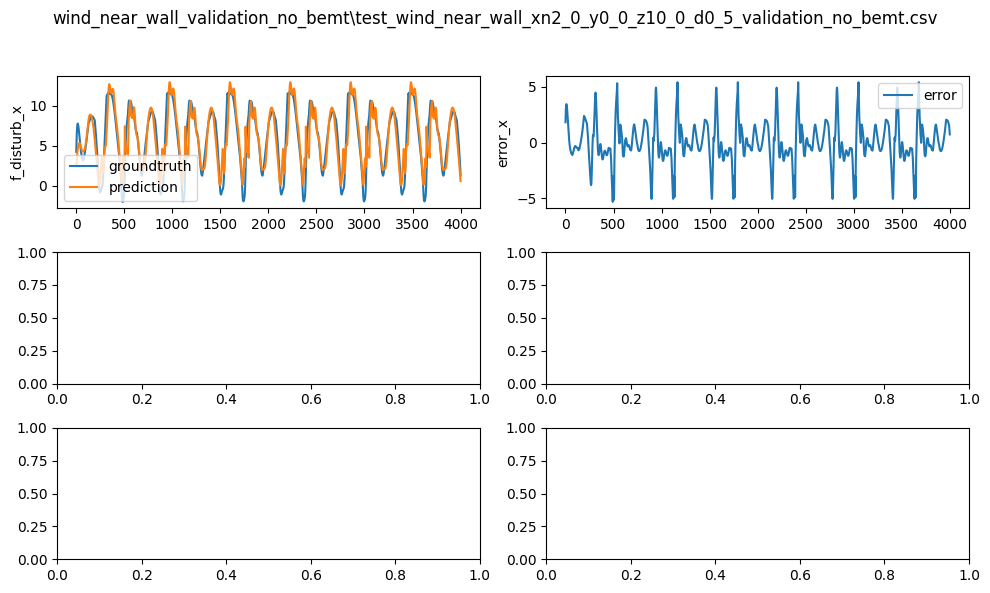

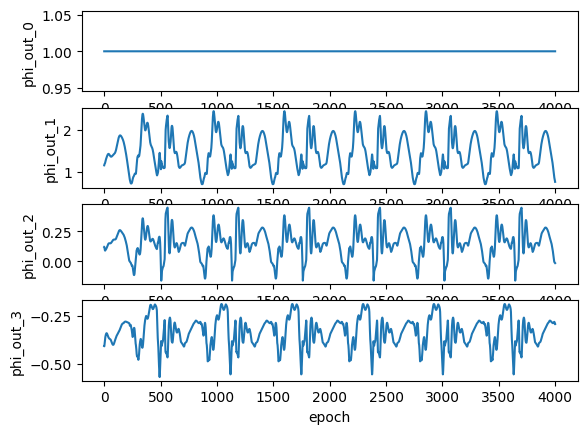

phi_out: tensor([[ 1.0000,  1.1610,  0.1203, -0.4078],
        [ 1.0000,  1.1651,  0.1203, -0.4085],
        [ 1.0000,  1.1684,  0.1201, -0.4088],
        ...,
        [ 1.0000,  0.8357,  0.0037, -0.3524],
        [ 1.0000,  0.8389,  0.0038, -0.3545],
        [ 1.0000,  0.8422,  0.0038, -0.3565]])
a = tensor([[-16.0077],
        [  8.8982],
        [-18.0701],
        [-21.1468]])


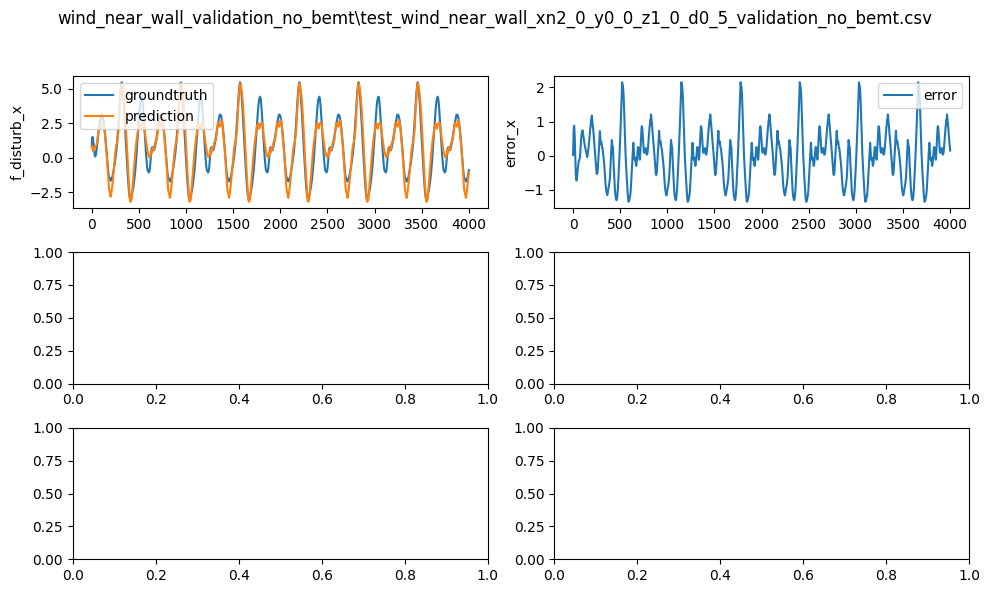

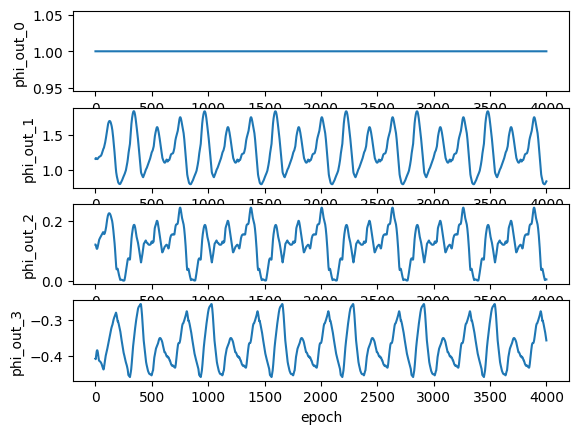

phi_out: tensor([[ 1.0000,  1.1624,  0.1206, -0.4083],
        [ 1.0000,  1.1735,  0.1209, -0.4101],
        [ 1.0000,  1.1831,  0.1188, -0.4072],
        ...,
        [ 1.0000,  0.8118, -0.0058, -0.3429],
        [ 1.0000,  0.8154, -0.0061, -0.3451],
        [ 1.0000,  0.8190, -0.0064, -0.3473]])
a = tensor([[-20.7952],
        [ 12.7238],
        [-29.3515],
        [-29.9010]])


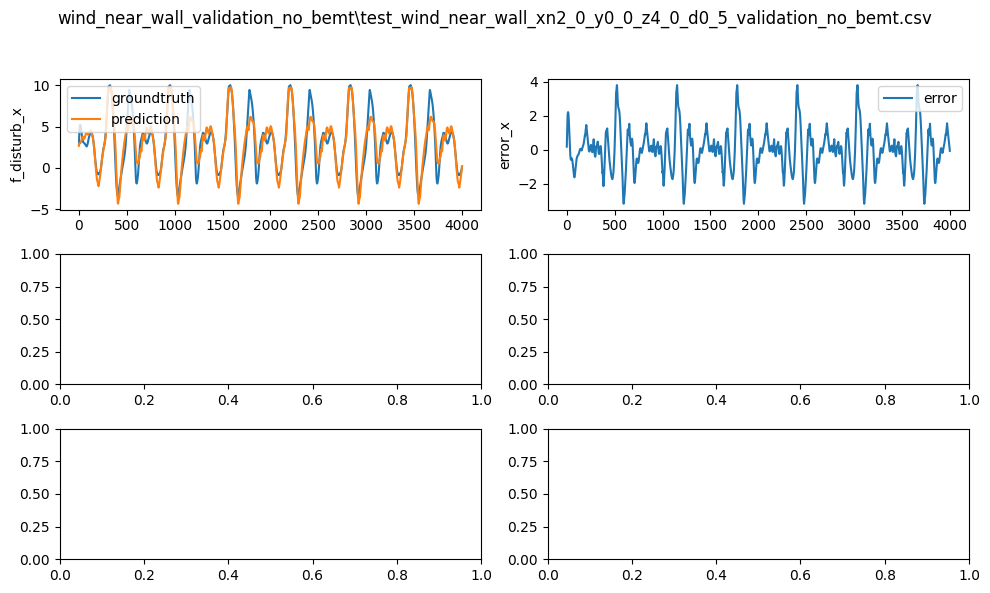

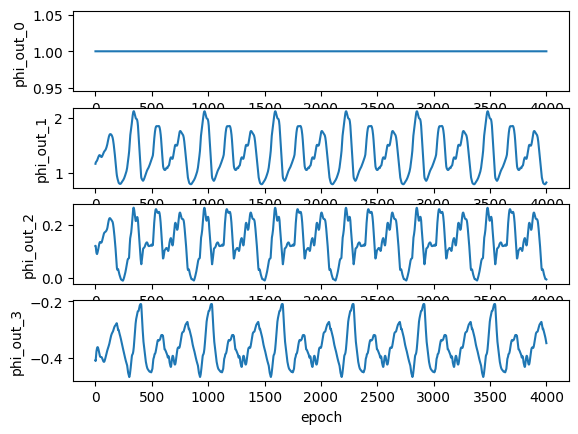

phi_out: tensor([[ 1.0000,  1.1639,  0.1208, -0.4088],
        [ 1.0000,  1.1802,  0.1195, -0.4085],
        [ 1.0000,  1.1889,  0.1138, -0.4006],
        ...,
        [ 1.0000,  0.8397,  0.0093, -0.3309],
        [ 1.0000,  0.8411,  0.0084, -0.3326],
        [ 1.0000,  0.8427,  0.0076, -0.3343]])
a = tensor([[ 1.0330],
        [ 0.1032],
        [ 7.8823],
        [-7.4831]])


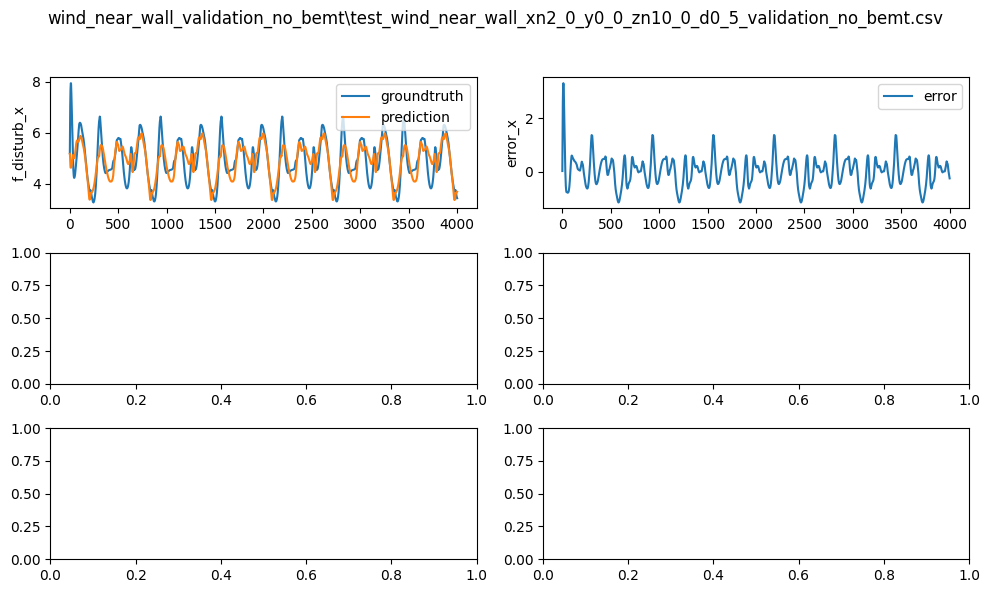

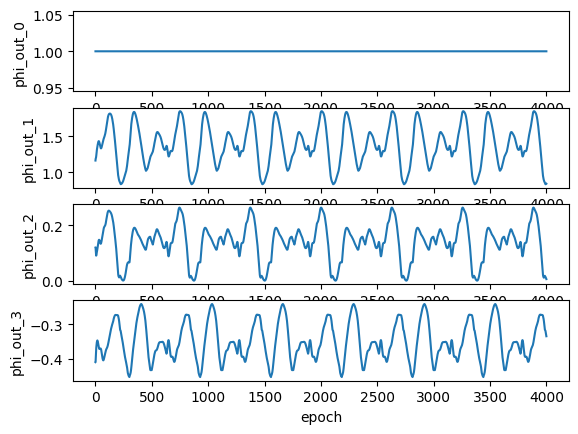

phi_out: tensor([[ 1.0000,  1.1602,  0.1202, -0.4075],
        [ 1.0000,  1.1602,  0.1200, -0.4076],
        [ 1.0000,  1.1596,  0.1198, -0.4076],
        ...,
        [ 1.0000,  0.8520,  0.0099, -0.3583],
        [ 1.0000,  0.8554,  0.0098, -0.3603],
        [ 1.0000,  0.8589,  0.0096, -0.3624]])
a = tensor([[-15.1582],
        [  7.6974],
        [-15.4886],
        [-19.7092]])


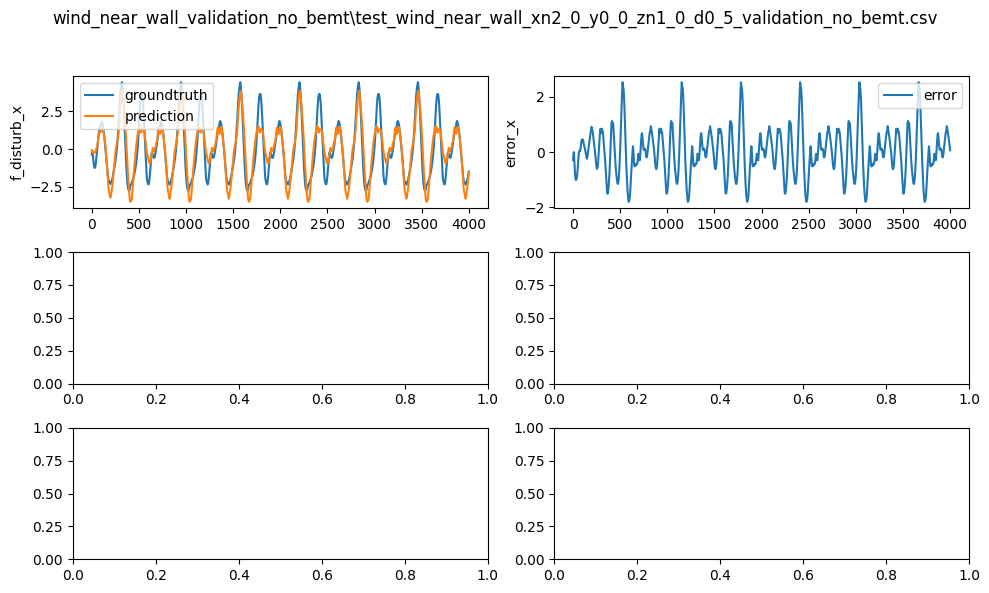

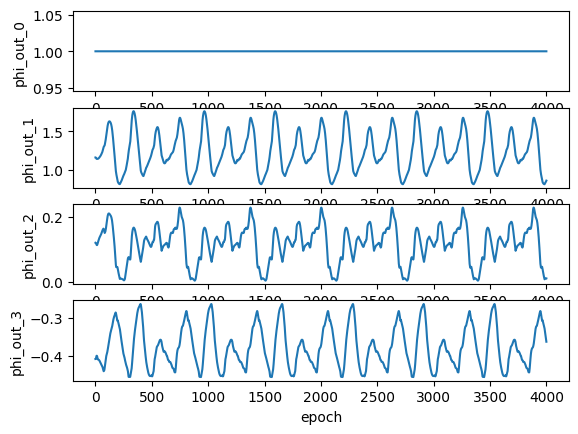

phi_out: tensor([[ 1.0000e+00,  1.1605e+00,  1.2021e-01, -4.0766e-01],
        [ 1.0000e+00,  1.1617e+00,  1.2001e-01, -4.0792e-01],
        [ 1.0000e+00,  1.1622e+00,  1.1979e-01, -4.0810e-01],
        ...,
        [ 1.0000e+00,  8.4192e-01,  1.1665e-04, -3.4961e-01],
        [ 1.0000e+00,  8.4532e-01,  1.9613e-04, -3.5180e-01],
        [ 1.0000e+00,  8.4876e-01,  2.6110e-04, -3.5398e-01]])
a = tensor([[ -8.4944],
        [  3.7494],
        [ -5.5057],
        [-12.5679]])


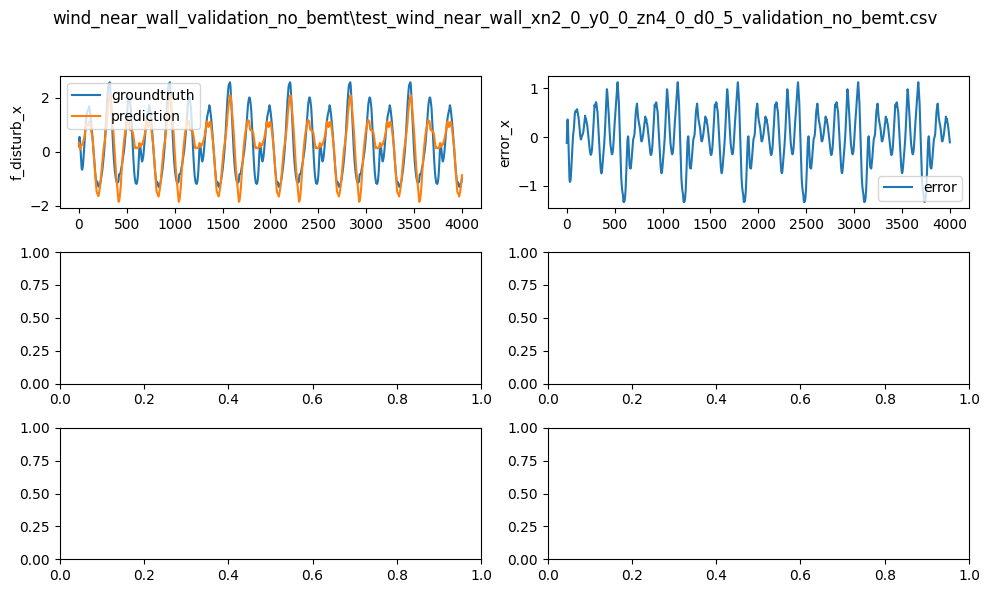

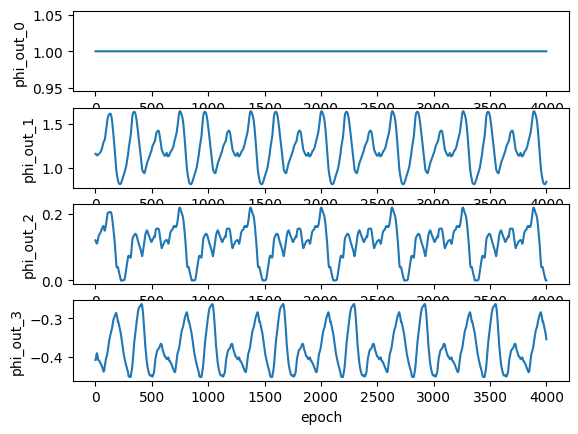

phi_out: tensor([[ 1.0000e+00,  1.1627e+00,  1.2044e-01, -4.0843e-01],
        [ 1.0000e+00,  1.1707e+00,  1.1883e-01, -4.0749e-01],
        [ 1.0000e+00,  1.1726e+00,  1.1347e-01, -3.9903e-01],
        ...,
        [ 1.0000e+00,  7.9572e-01,  1.4383e-03, -3.0524e-01],
        [ 1.0000e+00,  7.8886e-01,  5.7229e-04, -3.0551e-01],
        [ 1.0000e+00,  7.8443e-01, -8.0513e-04, -3.0668e-01]])
a = tensor([[ -5.4841],
        [ 10.5505],
        [-16.9532],
        [  5.5457]])


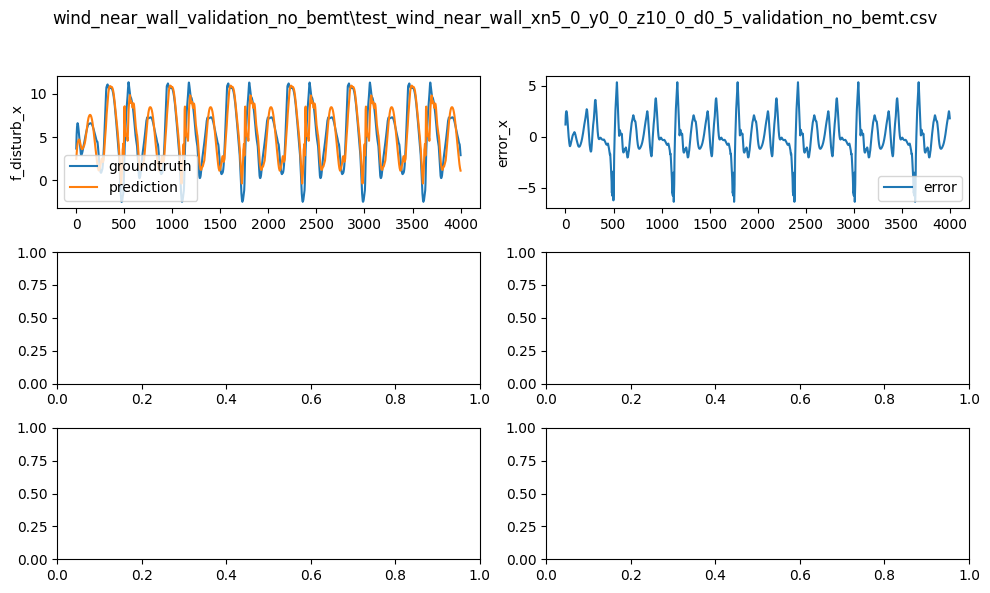

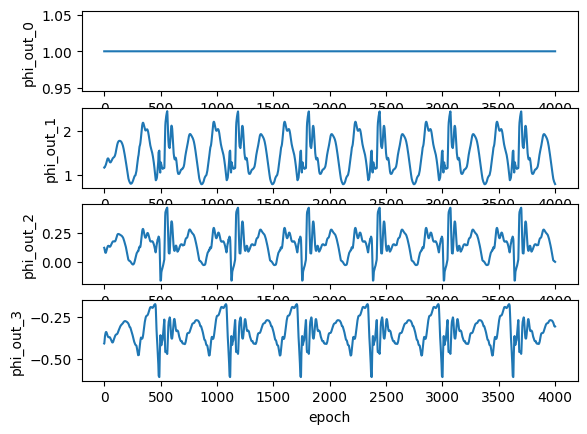

phi_out: tensor([[ 1.0000,  1.1611,  0.1202, -0.4079],
        [ 1.0000,  1.1634,  0.1199, -0.4084],
        [ 1.0000,  1.1646,  0.1180, -0.4059],
        ...,
        [ 1.0000,  0.8326, -0.0030, -0.3448],
        [ 1.0000,  0.8352, -0.0036, -0.3467],
        [ 1.0000,  0.8377, -0.0043, -0.3485]])
a = tensor([[-14.8170],
        [  8.8368],
        [-18.7895],
        [-19.2432]])


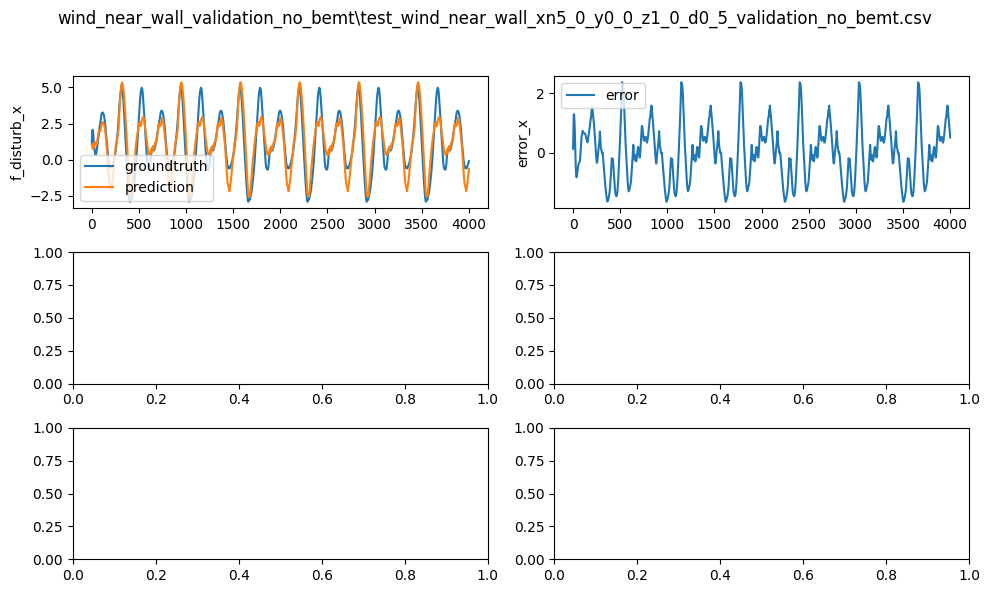

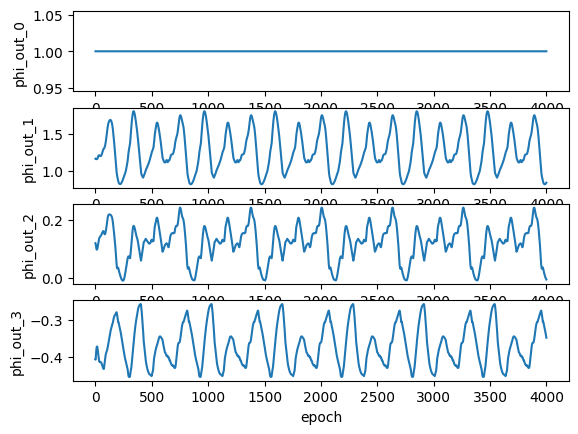

phi_out: tensor([[ 1.0000,  1.1619,  0.1203, -0.4082],
        [ 1.0000,  1.1670,  0.1195, -0.4084],
        [ 1.0000,  1.1688,  0.1157, -0.4024],
        ...,
        [ 1.0000,  0.8228,  0.0048, -0.3340],
        [ 1.0000,  0.8244,  0.0046, -0.3353],
        [ 1.0000,  0.8261,  0.0045, -0.3367]])
a = tensor([[-19.7112],
        [ 14.8438],
        [-49.9461],
        [-27.8070]])


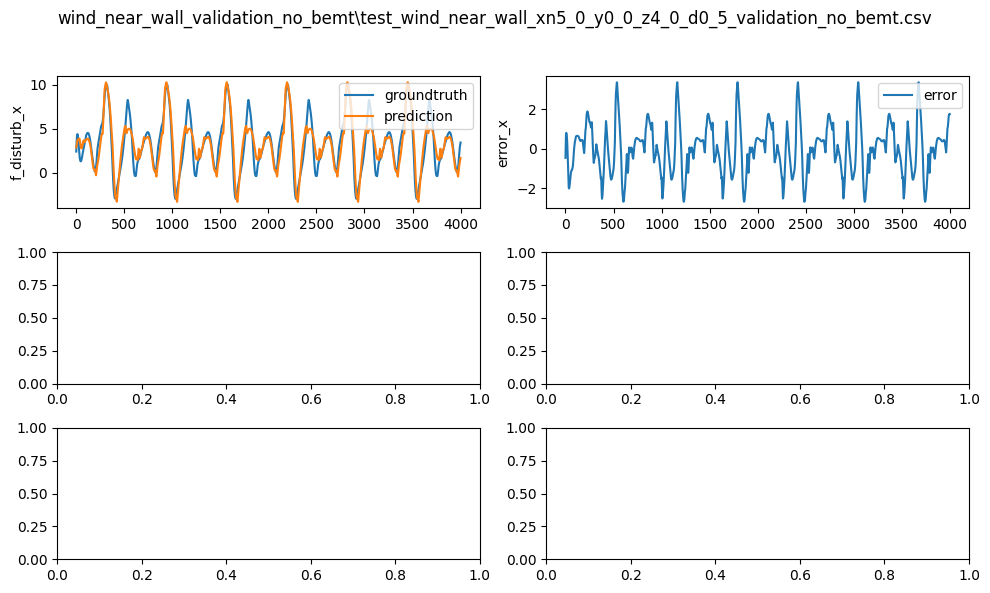

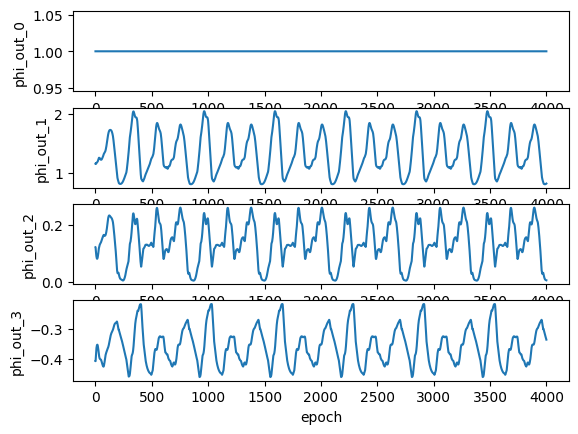

phi_out: tensor([[ 1.0000,  1.1636,  0.1205, -0.4088],
        [ 1.0000,  1.1728,  0.1173, -0.4052],
        [ 1.0000,  1.1733,  0.1092, -0.3937],
        ...,
        [ 1.0000,  0.8625,  0.0125, -0.3383],
        [ 1.0000,  0.8643,  0.0117, -0.3401],
        [ 1.0000,  0.8663,  0.0109, -0.3419]])
a = tensor([[ 0.7445],
        [-0.4719],
        [14.4979],
        [-8.1563]])


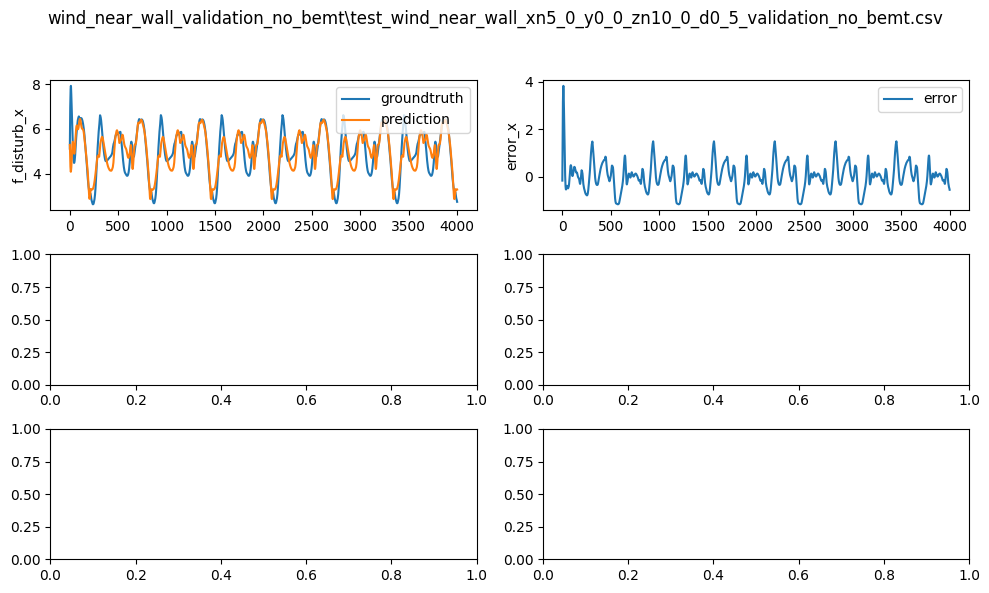

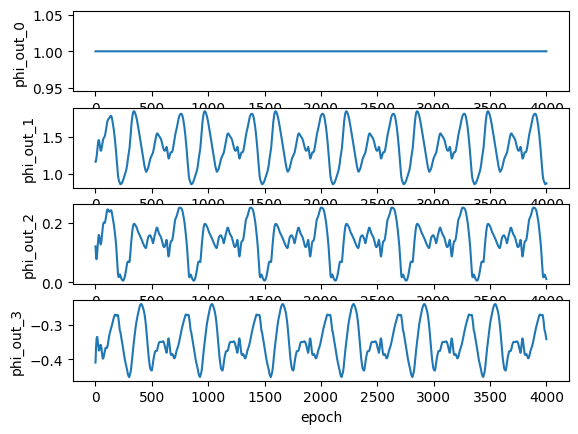

phi_out: tensor([[ 1.0000e+00,  1.1604e+00,  1.2013e-01, -4.0763e-01],
        [ 1.0000e+00,  1.1591e+00,  1.1961e-01, -4.0753e-01],
        [ 1.0000e+00,  1.1574e+00,  1.1875e-01, -4.0674e-01],
        ...,
        [ 1.0000e+00,  8.4401e-01, -3.9889e-04, -3.4891e-01],
        [ 1.0000e+00,  8.4694e-01, -4.8483e-04, -3.5085e-01],
        [ 1.0000e+00,  8.4997e-01, -6.0968e-04, -3.5278e-01]])
a = tensor([[-13.7011],
        [  7.6007],
        [-16.5441],
        [-17.5648]])


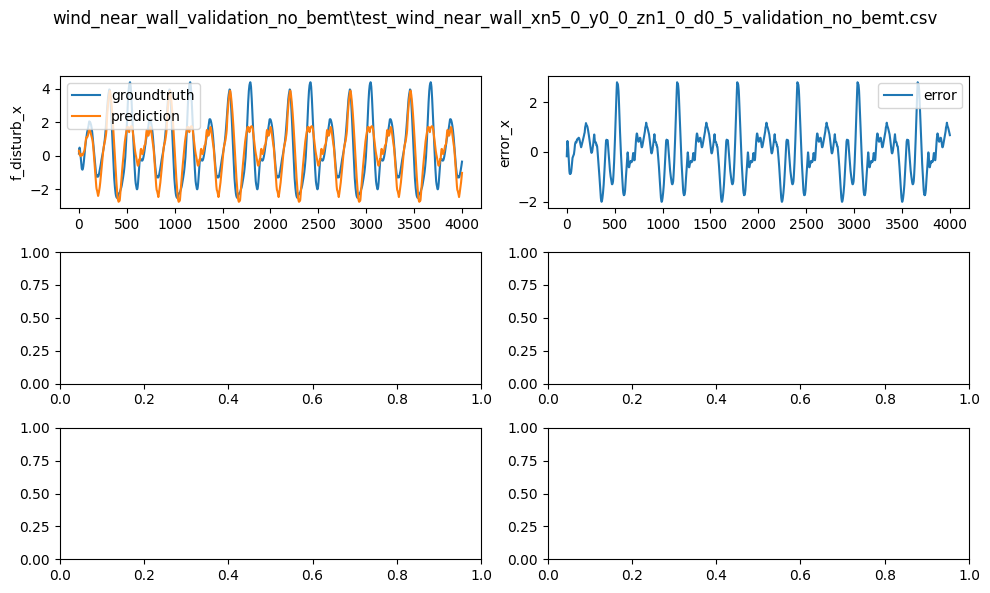

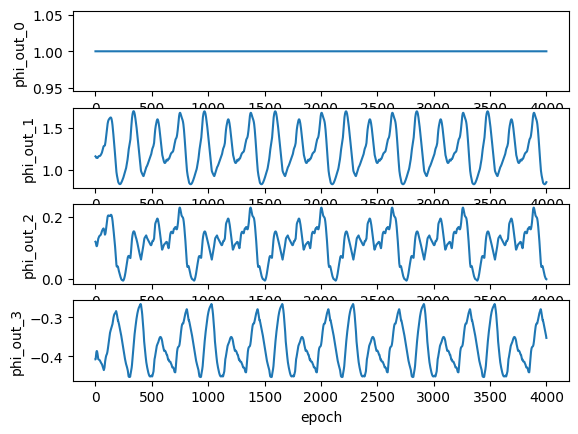

phi_out: tensor([[ 1.0000,  1.1604,  0.1201, -0.4077],
        [ 1.0000,  1.1576,  0.1193, -0.4073],
        [ 1.0000,  1.1541,  0.1174, -0.4049],
        ...,
        [ 1.0000,  0.8615,  0.0035, -0.3547],
        [ 1.0000,  0.8650,  0.0035, -0.3569],
        [ 1.0000,  0.8686,  0.0035, -0.3590]])
a = tensor([[ -8.7168],
        [  3.5802],
        [ -2.3357],
        [-13.1029]])


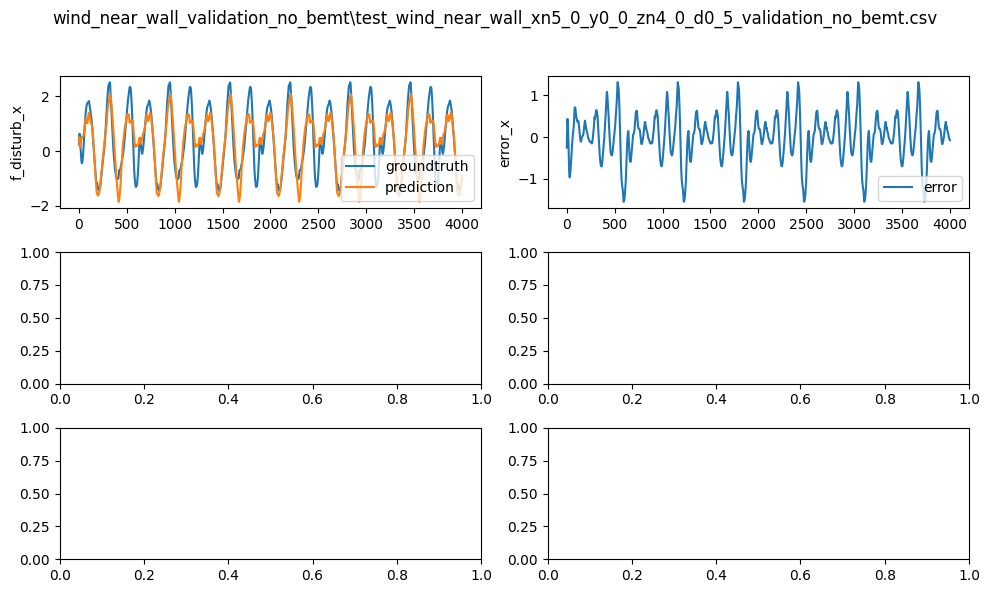

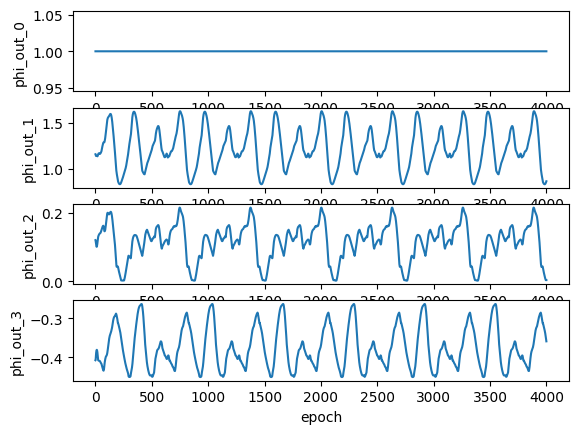

average rms for dim 0: 0.9769443511695803


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:143: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


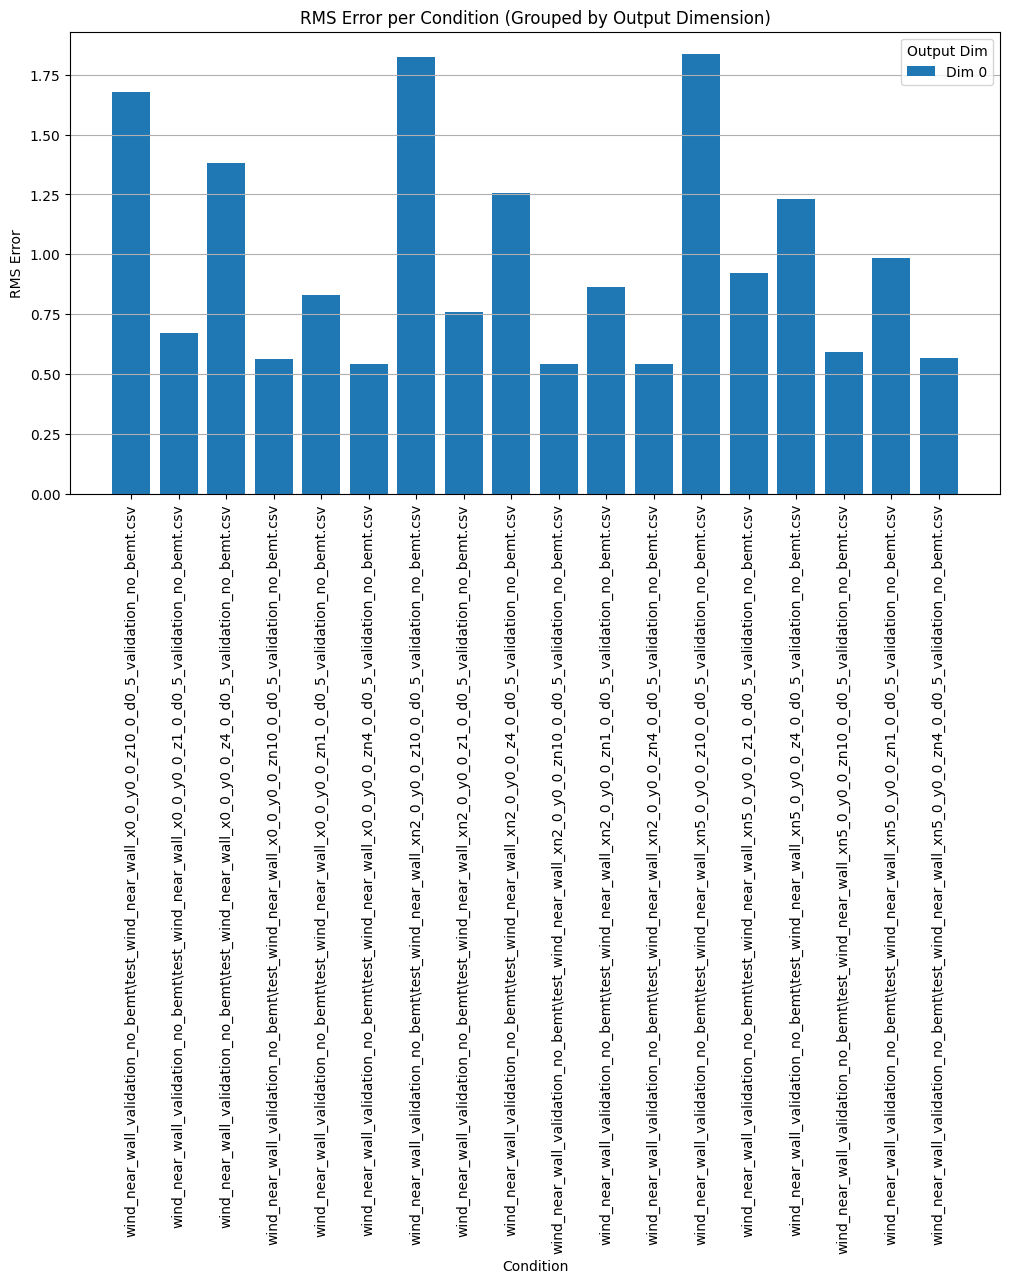

average mse for dim 0: 1.1484120781758163


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:169: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


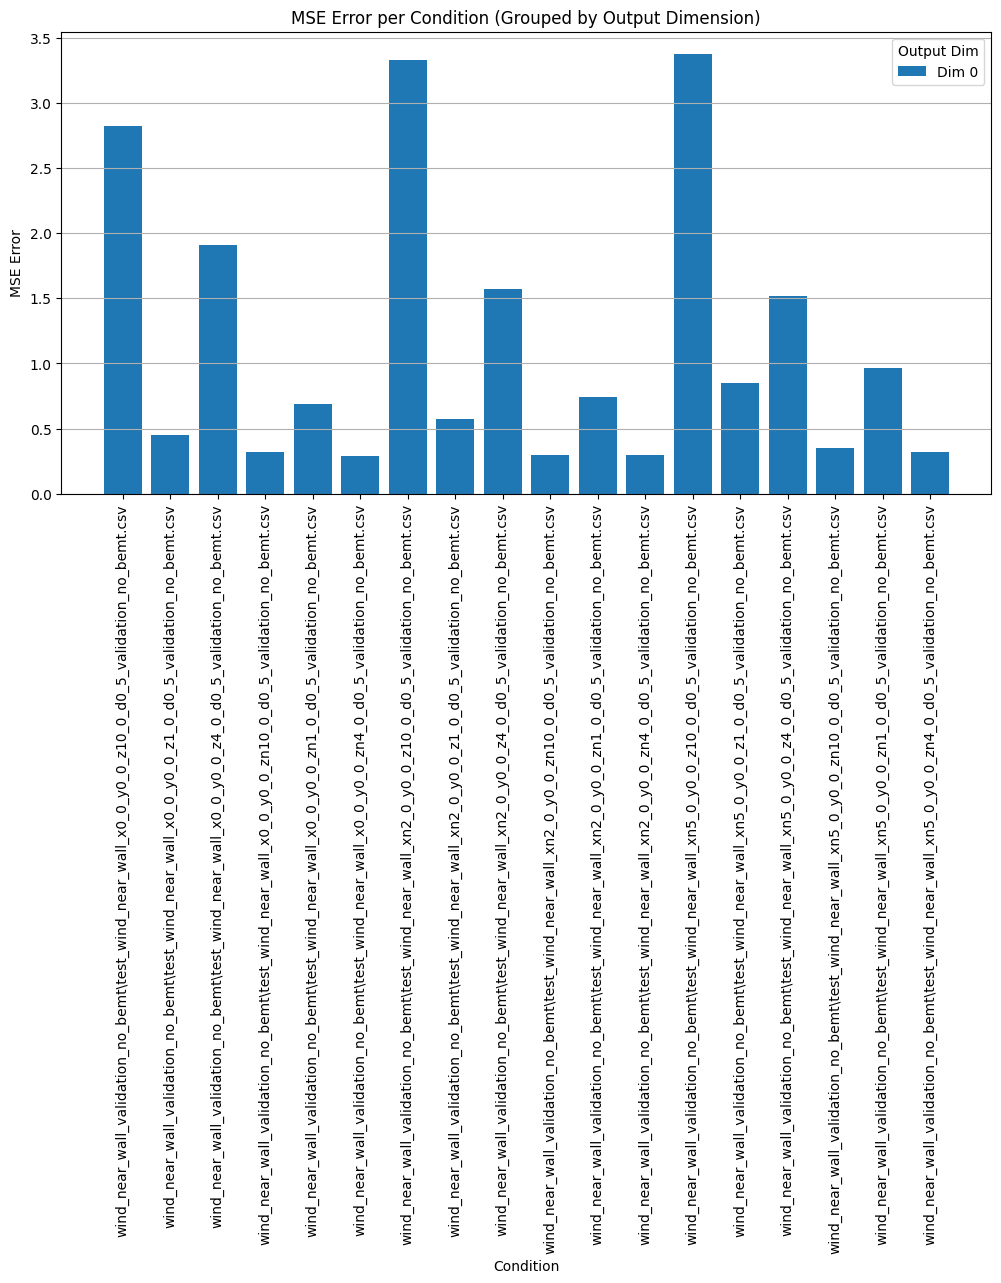

In [6]:
%matplotlib inline
model_name = training_subfolder

# subfolder = "wind_near_wall_validation_bemt"
subfolder = "wind_near_wall_validation_no_bemt"
# subfolder = "nf_validation_back2back"
data_list = generate_data_list(subfolder)
print("test Data List:")
for data in data_list:
    print(data)

# debug
# data_list = data_list[:1]  # use small data list for quick testing

manager = training_manager.TestManager()
manager.set_up(
    data_menu=data_list,
    input_label_map_file=path1,
    column_map_file=path2,
    can_skip_io_normalizaiton=False
)

phi, h = training_manager.load_model(model_name)
# make a new trainer to replicate the above setup, just to allow verify_model to work
manager.test(phi, h, data_list)
plt.show()  
